In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gwpy.plot import Plot
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
import generation_signal
from likelihood_calculation import minimisation_locale, minimisation_globale, print_results, likelihood_visualisation
from plot_functions import plot_mnimisation, plot_dual_local_minimisation, plot_correlation, plot_correlation_2_params, plot_correlation_chirp_q


### Génération du signal
Paramètre du signal initial que l'on génère :

In [2]:
seglen = 4
sample_rate = 2048
fmin = 5.
# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
            # Paramètres intrinsèques à la source
            'mass1': 38.6,
            'mass2': 29.3,
            'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
            'eccentricity': 0,
            # Paramètres extrinsèques
            'ra': 1.37, 'dec': -1.26, 'distance': 1000,
            'polarization': 2.76, 'inclination': 0,
            'tc': 3.1 , 'coa_phase': 0}

approximant='IMRPhenomD'

para_reels = np.array([cbc_params['tc'],cbc_params['mass1'], cbc_params['mass2'],cbc_params['distance'],
                       cbc_params['ra'], cbc_params['dec'],cbc_params['polarization'],
                       cbc_params['inclination'],cbc_params['spin1z'],cbc_params['spin2z']])

signal = generation_signal.Signal_GW(seglen,sample_rate,fmin,cbc_params,approximant)

Génération selon les appareils de ET :

In [3]:
signalGW_ET = signal.signal_ET()
print(signalGW_ET)

{'E1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fad4369d640>, 'E2': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fad3977cac0>, 'E3': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fad3977cf10>}


Génération selon LIGO (H1,L1) :

In [30]:
signalGW_LIGO = signal.signal_LIGO()
print(signalGW_LIGO)

{'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fcbde1096d0>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fcbde109f40>}


Comparaison en fréquence des différents interféromètres :

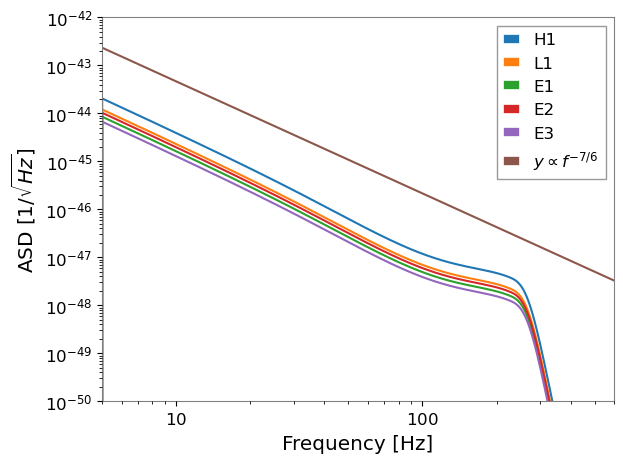

In [6]:
plt.loglog(signalGW_LIGO['H1'].get_sample_frequencies(), np.abs(signalGW_LIGO['H1'])**2,label='H1')
plt.loglog(signalGW_LIGO['L1'].get_sample_frequencies(), np.abs(signalGW_LIGO['L1'])**2, label='L1')
plt.loglog(signalGW_ET['E1'].get_sample_frequencies(), np.abs(signalGW_ET['E1'])**2,label='E1')
plt.loglog(signalGW_ET['E2'].get_sample_frequencies(), np.abs(signalGW_ET['E2'])**2,label='E2')
plt.loglog(signalGW_ET['E3'].get_sample_frequencies(), np.abs(signalGW_ET['E3'])**2,label='E3')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [1/$\sqrt{Hz}]$')
y = signalGW_LIGO['H1'].get_sample_frequencies()**(-7/3)
#plt.loglog(signal_H1L1['H1'].get_sample_frequencies(), 1e-41*y, label=r'$y\propto f^{-7/6}$')
plt.loglog(signalGW_ET['E1'].get_sample_frequencies(), 1e-41*y, label=r'$y\propto f^{-7/6}$')
plt.legend()
plt.ylim(1e-50, 1e-42)
plt.xlim(5, 600)
plt.grid()
plt.tight_layout()
plt.savefig('Telescopes_ET_LIGO_comparaison')

### (CHOIX1) Signal sans buit

In [4]:
model_normal, signal_normal = signal.signal_simple(signalGW_ET)

### (CHOIX2) Signal avec bruit

In [5]:
model_noise, signal_noise = signal.signal_noise(signalGW_ET)

In [6]:
model_noise.update(**cbc_params)
print('Log likelihood: {:.2f}'.format(model_noise.loglikelihood))
print('Log likelihood noise: {:.2f}'.format(model_noise.lognl))
print('Log likelihood ratio: {:.2f}'.format(model_noise.loglr))

Log likelihood: -12156.52
Log likelihood noise: -152921.76
Log likelihood ratio: 140765.23


In [7]:
snr_E1_sq = model_noise.det_optimal_snrsq('E1')
snr_E2_sq = model_noise.det_optimal_snrsq('E2')
snr_E3_sq = model_noise.det_optimal_snrsq('E3')

log_noise_likelihood_from_SNR = -0.5 * (snr_E1_sq + snr_E2_sq + snr_E3_sq)

print('SNR E1: {:.2f}'.format(snr_E1_sq**0.5))
print('SNR E2: {:.2f}'.format(snr_E2_sq**0.5))
print('SNR E3: {:.2f}'.format(snr_E3_sq**0.5))

print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

SNR E1: 306.29
SNR E2: 337.09
SNR E3: 272.18
Expected log likelihood noise: -140763.49


### Minimisation en utilisant un DataFrame : minimums LOCAUX

Fonction scipy.optimize.minimize.

In [8]:
mass1_init = 29
mass2_init = 36
tol=10
initial_params = [3.1, mchirp_from_mass1_mass2(cbc_params['mass1'],cbc_params['mass2']),
                   q_from_mass1_mass2(cbc_params['mass1'],cbc_params['mass2']), 1000, 1.37, -1.26,2.76,0,0,0]
result, initial_params = minimisation_locale(model_noise,initial_params,tol,
                                             log_noise_likelihood_from_SNR,follow_lik=True,save_data=True)

Expected log likelihood noise: -140763.49


In [9]:
print_results(result,para_reels,initial_params)

Paramètres initiaux :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0, s1z : 0, s2z : 0.

Paramètres d'optimisation trouvés (local) :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0.0, s1z : -0.0, s2z : -0.0.

Paramètres réels :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0.0, s1z : 0.0, s2z : 0.0.


Charger les données depuis un fichier csv :

In [10]:
params_dataFrame = pd.read_csv("data_files/params_dataFrame_file_chirp_noise.txt")
para_opti = params_dataFrame.loc[params_dataFrame['mloglik'].idxmin()]
initial_params = [3.1, mchirp_from_mass1_mass2(cbc_params['mass1'],cbc_params['mass2']),
                   q_from_mass1_mass2(cbc_params['mass1'],cbc_params['mass2']), 1000, 1.37, -1.26,2.76,0,0,0]

Création des listes associées aux paramètres à partir du DataFrame. Premier plot de l'évolution de la minimisation $t_c$ et $m_1$.

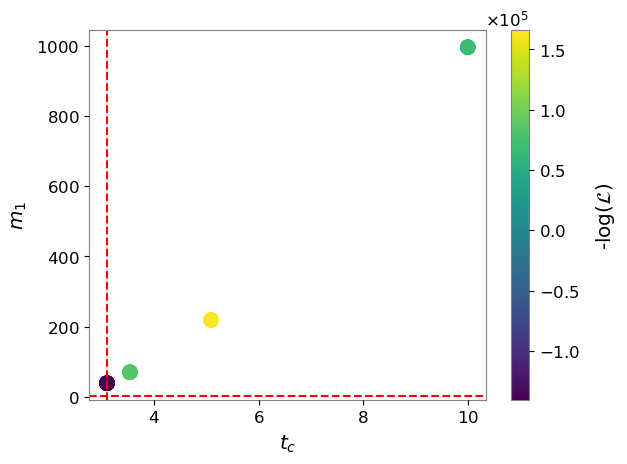

In [11]:
plot_dual_local_minimisation(params_dataFrame,x_data='tc',y_data='mass1',x_label=r"$t_c$",y_label=r"$m_1$",save_fig=False)

Plot des graphs d'évolution de la minimisation pour toutes les combinaisons de paramètres associées à notre minimisation : minimums LOCAUX.

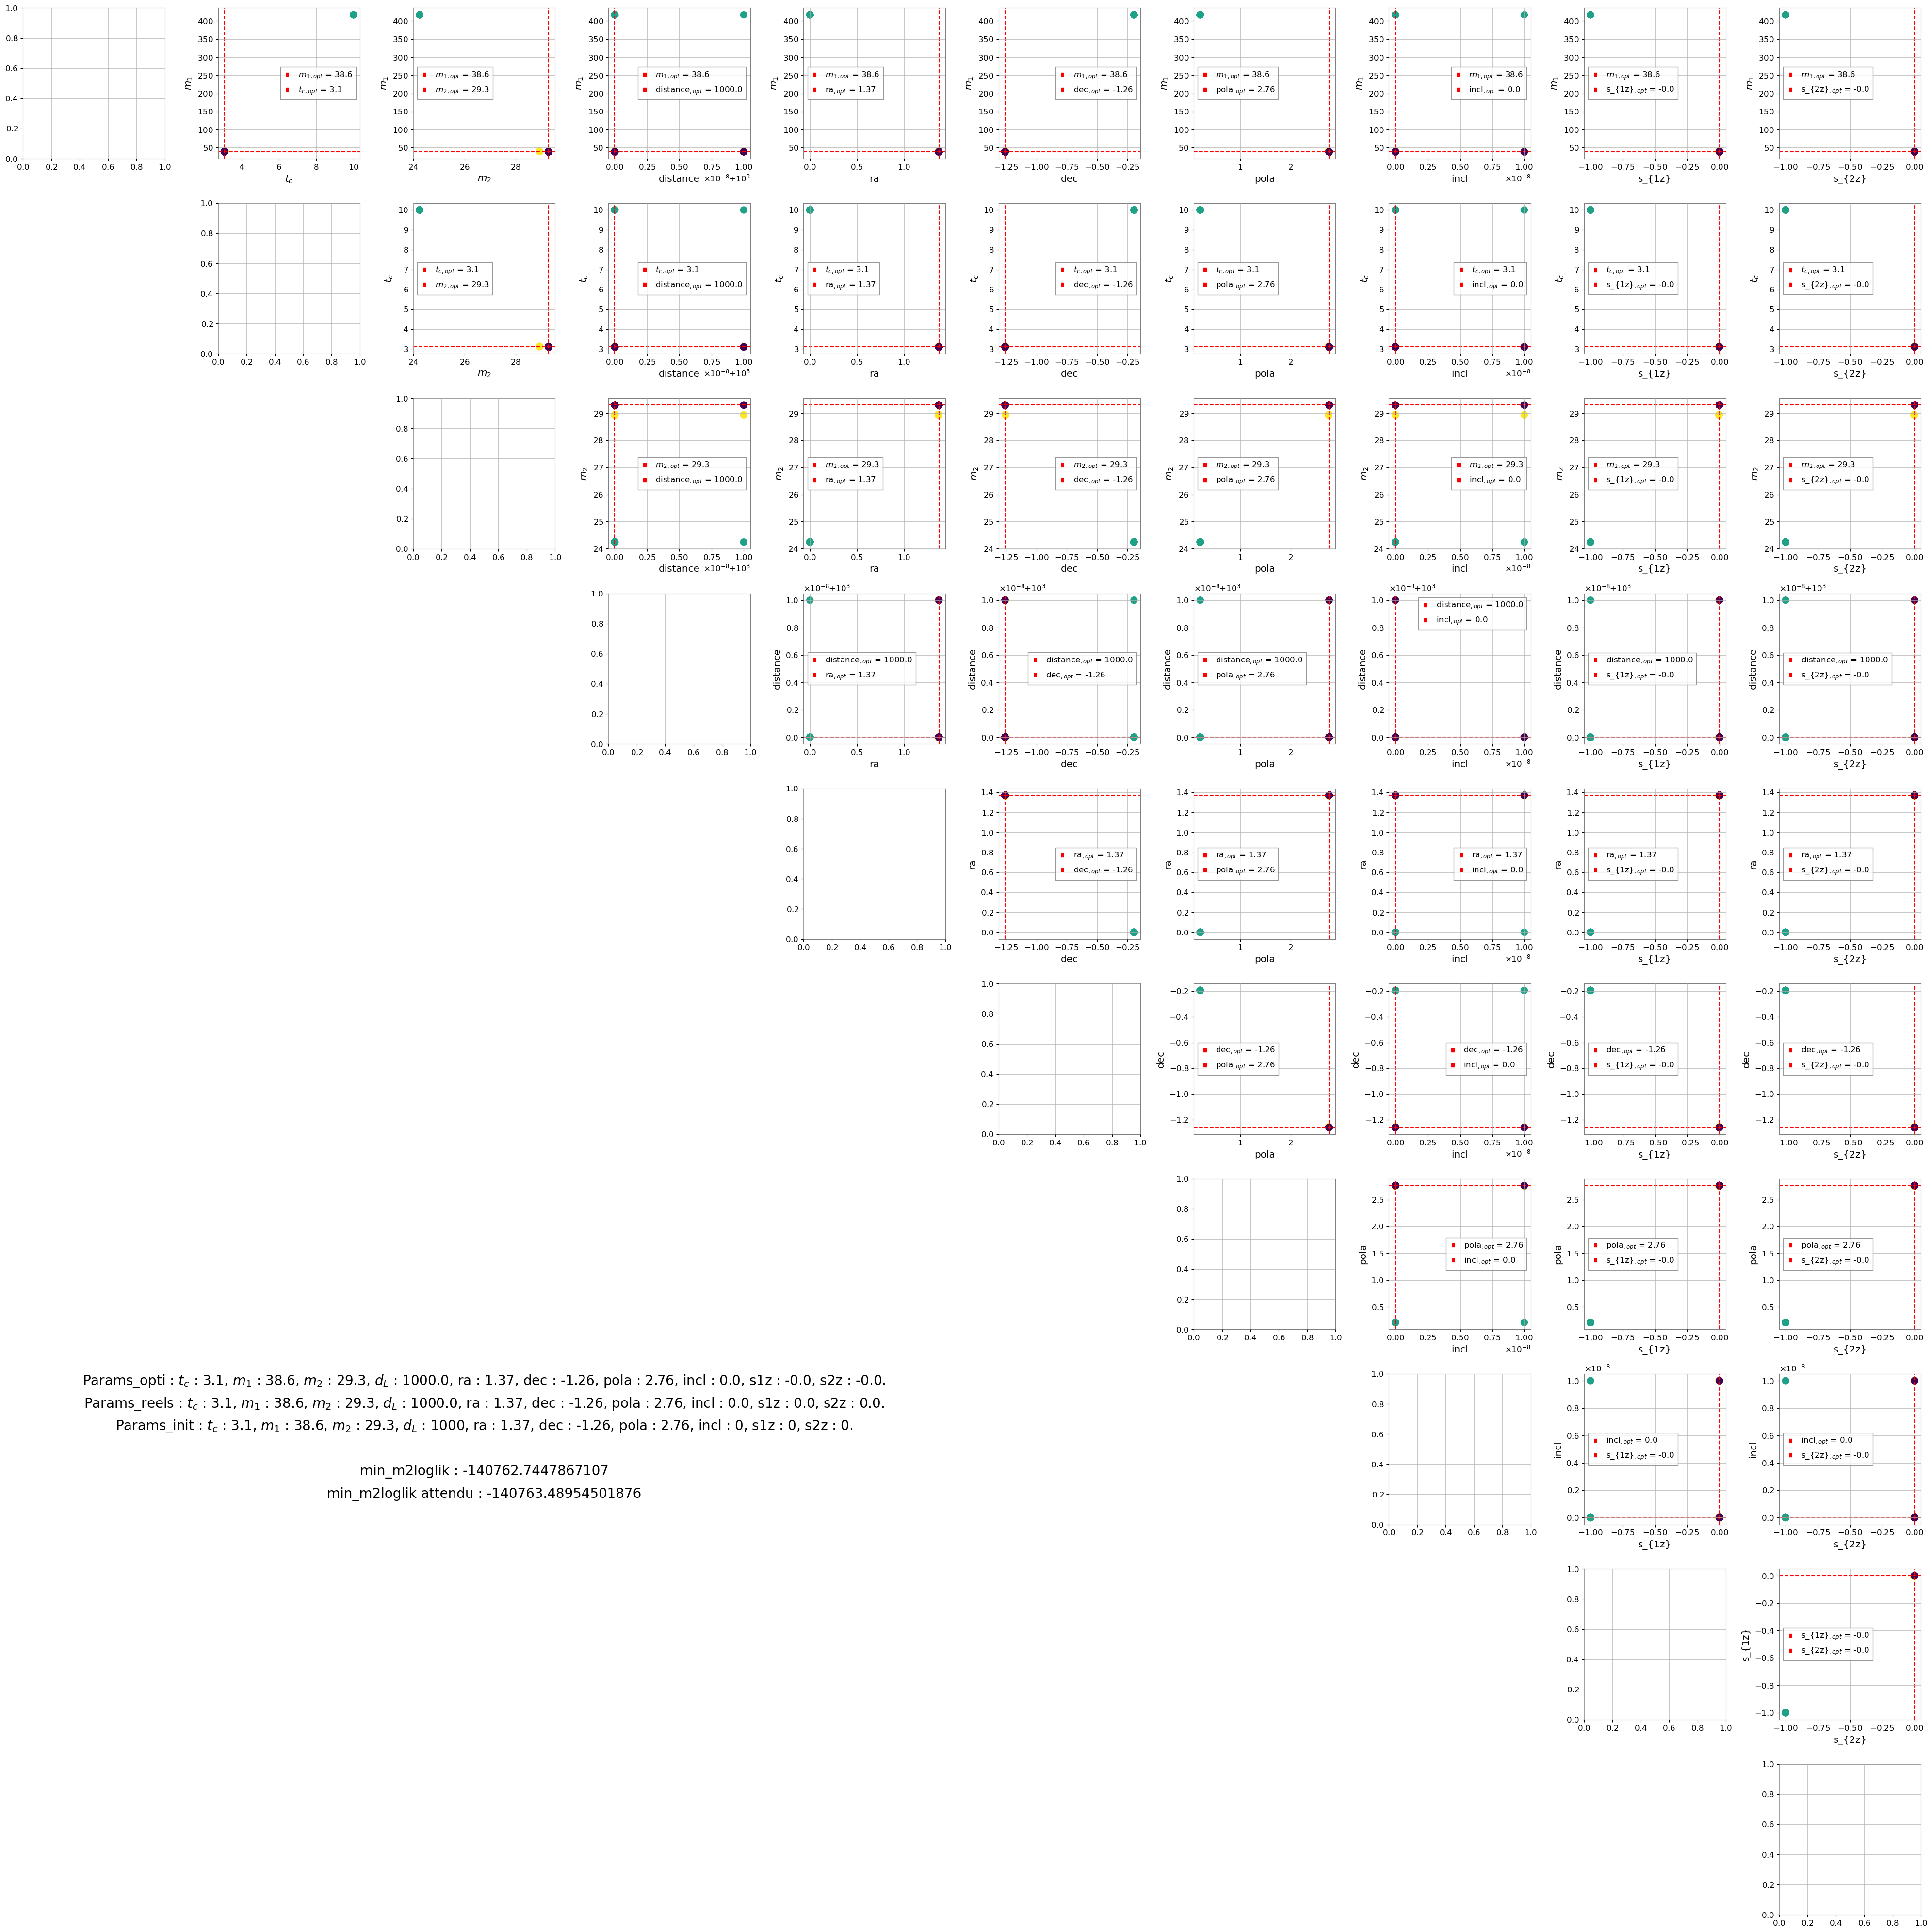

In [11]:
#Il est nécessaire de charger les données issues d'un Dataframe.
plot_mnimisation(params_dataFrame,para_opti,para_reels,initial_params,log_noise_likelihood_from_SNR,mini='loc',save_fig=False)

### Minimisation en utilisant un DataFrame : minimums GLOBAUX

On utilise cette fois la fonction scipy.optimize.basinhopping.

In [ ]:
#Nelder-Mead,  Powell, L-BFGS-B
result_glob = minimisation_globale(model=model_noise,method="L-BFGS-B",minimisation='basinhopping',
                                   tol=10,nb_iter=100,log_noise_likelihood_from_SNR=log_noise_likelihood_from_SNR,
                                   normalisation=False,save_data=False)

Expected log likelihood noise: -140763.49
min : -222.10292453945047, it : 1
min : -1292.7621102710305, it : 2
min : -1312.1040556439111, it : 3
min : -2278.873321493529, it : 5
min : -6632.716968934048, it : 7
min : -6693.283623359619, it : 8
min : -6738.572879178308, it : 9
min : -8495.787073347592, it : 10


KeyboardInterrupt: 

In [8]:
result_glob = minimisation_globale(model=model_noise,method="L-BFGS-B",minimisation='differential_evolution',
                                   tol=10,nb_iter=100,log_noise_likelihood_from_SNR=log_noise_likelihood_from_SNR,
                                   normalisation=False,save_data=False)

Expected log likelihood noise: -140763.49


KeyboardInterrupt: 

(OPTION) Récupérer des données issues d'un fichier data.

In [29]:
nom_fichier = 'params_glob_dataFrame_file_chirp.txt'

params_dataFrame_glob = pd.read_csv("data_files/" + nom_fichier)
para_opti = params_dataFrame_glob.loc[params_dataFrame_glob['mloglik'].idxmin()]

0

1raph 1 fini

2raph 2 fini

3raph 3 fini

4raph 4 fini

5raph 5 fini

6raph 6 fini

7raph 7 fini

8raph 8 fini

9raph 9 fini



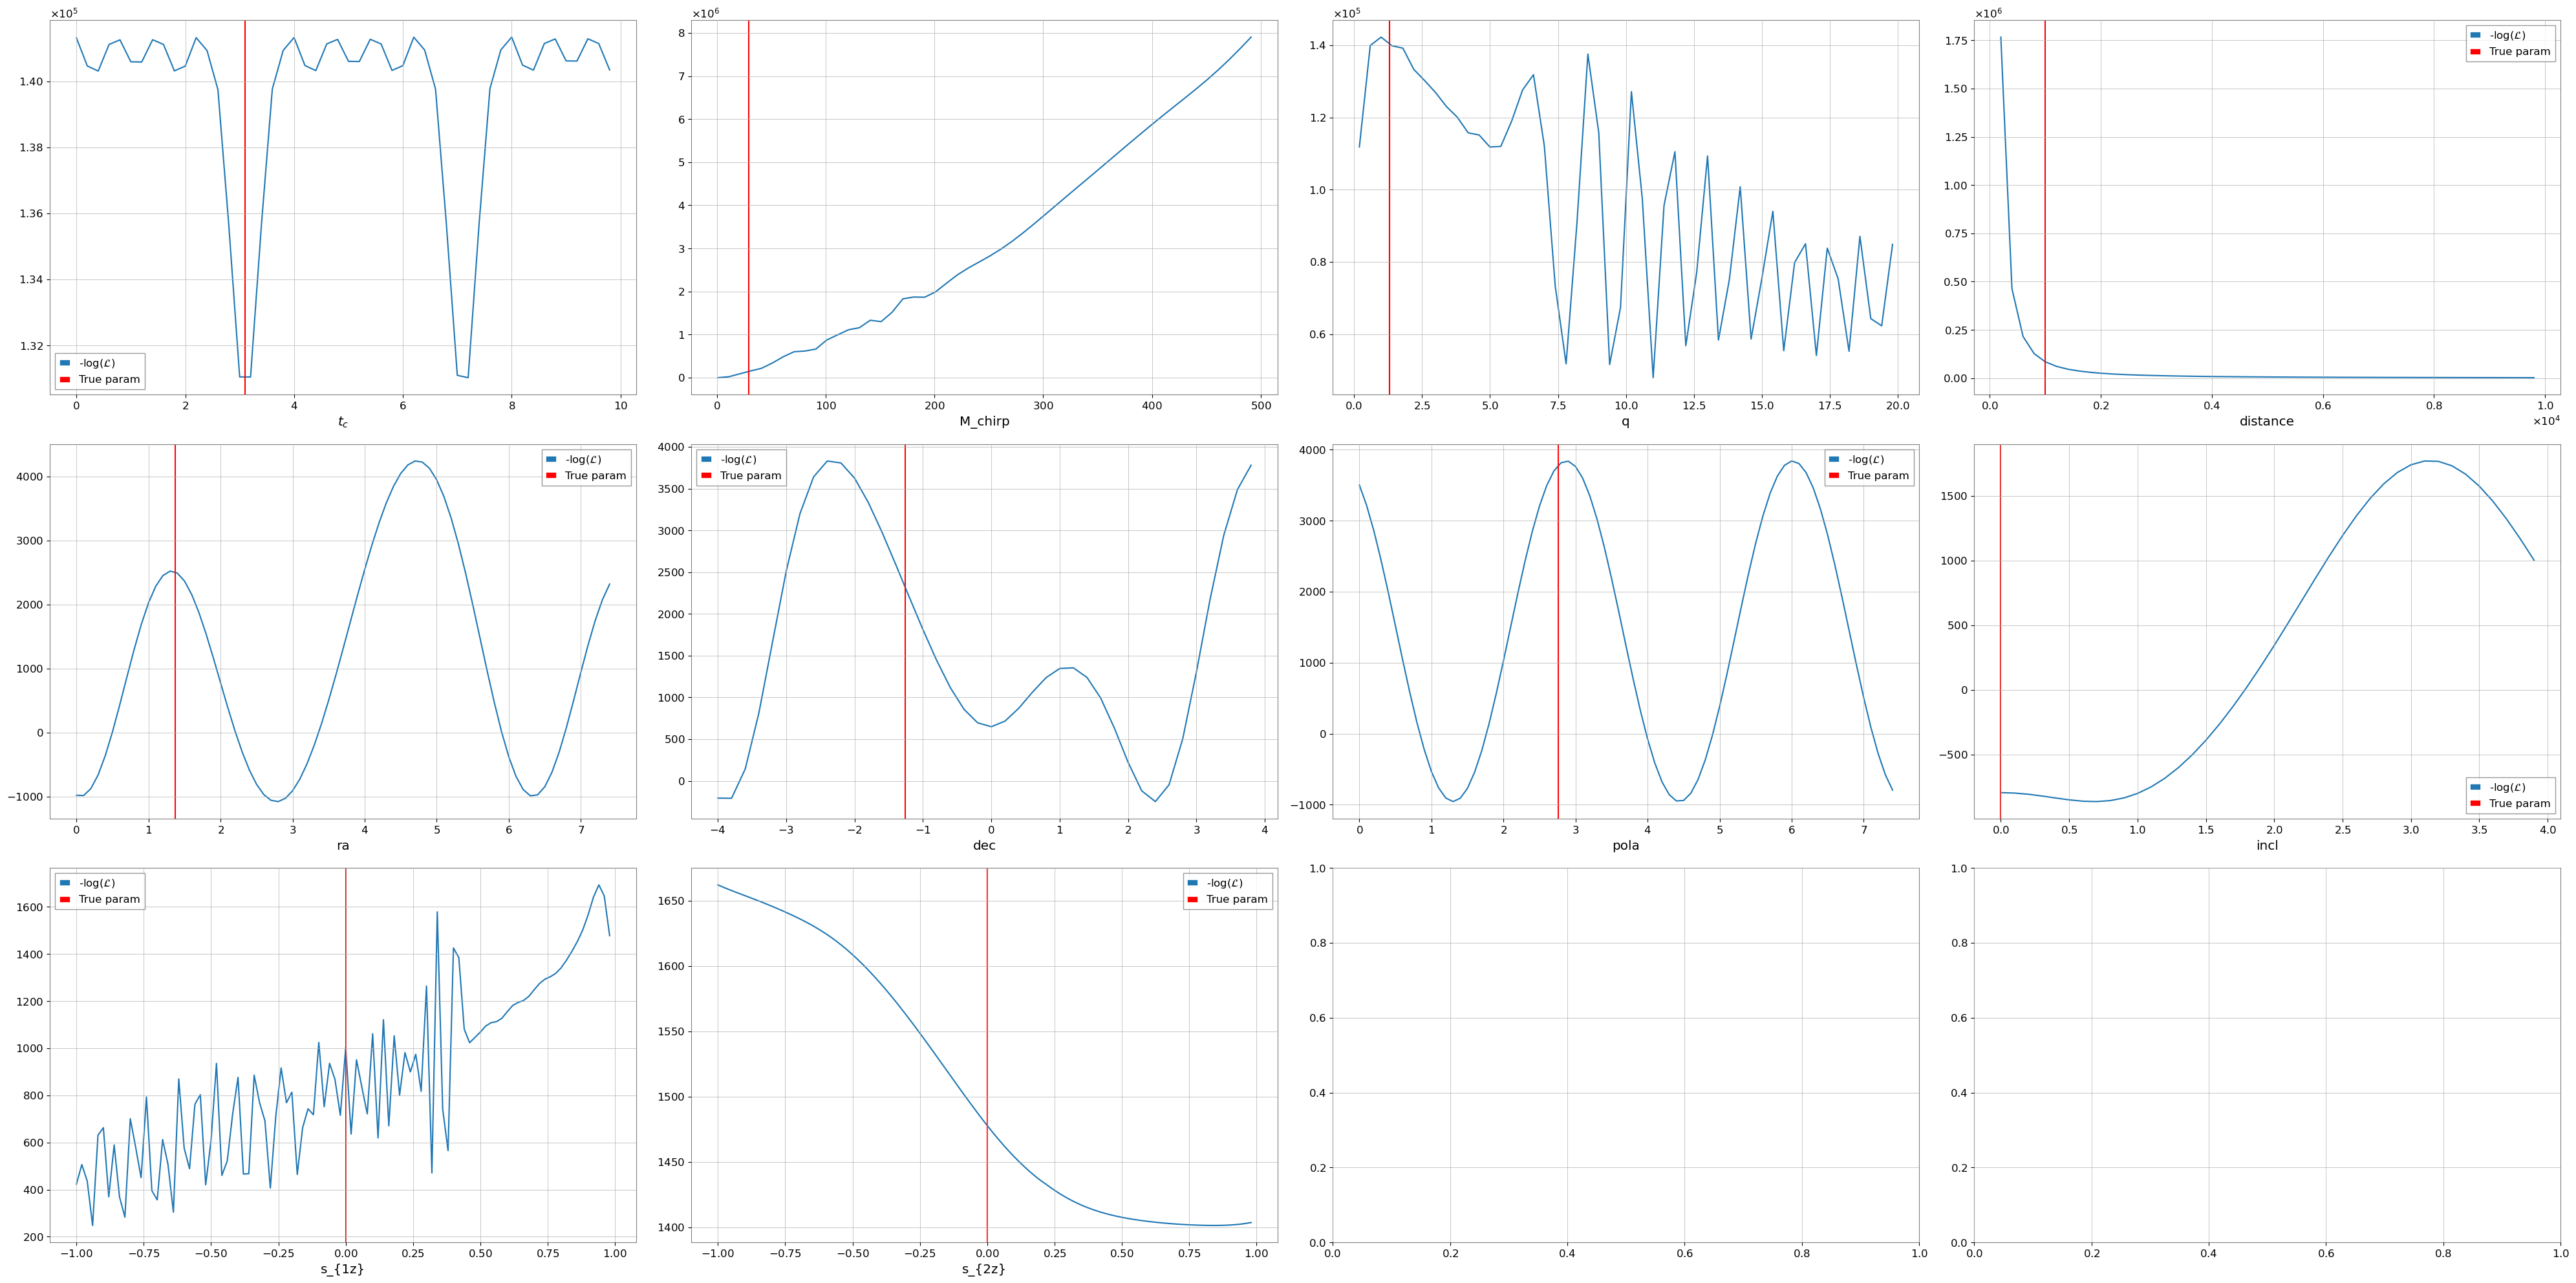

In [13]:
likelihood_visualisation(model_noise,params_dataFrame,para_reels,save_fig=False)

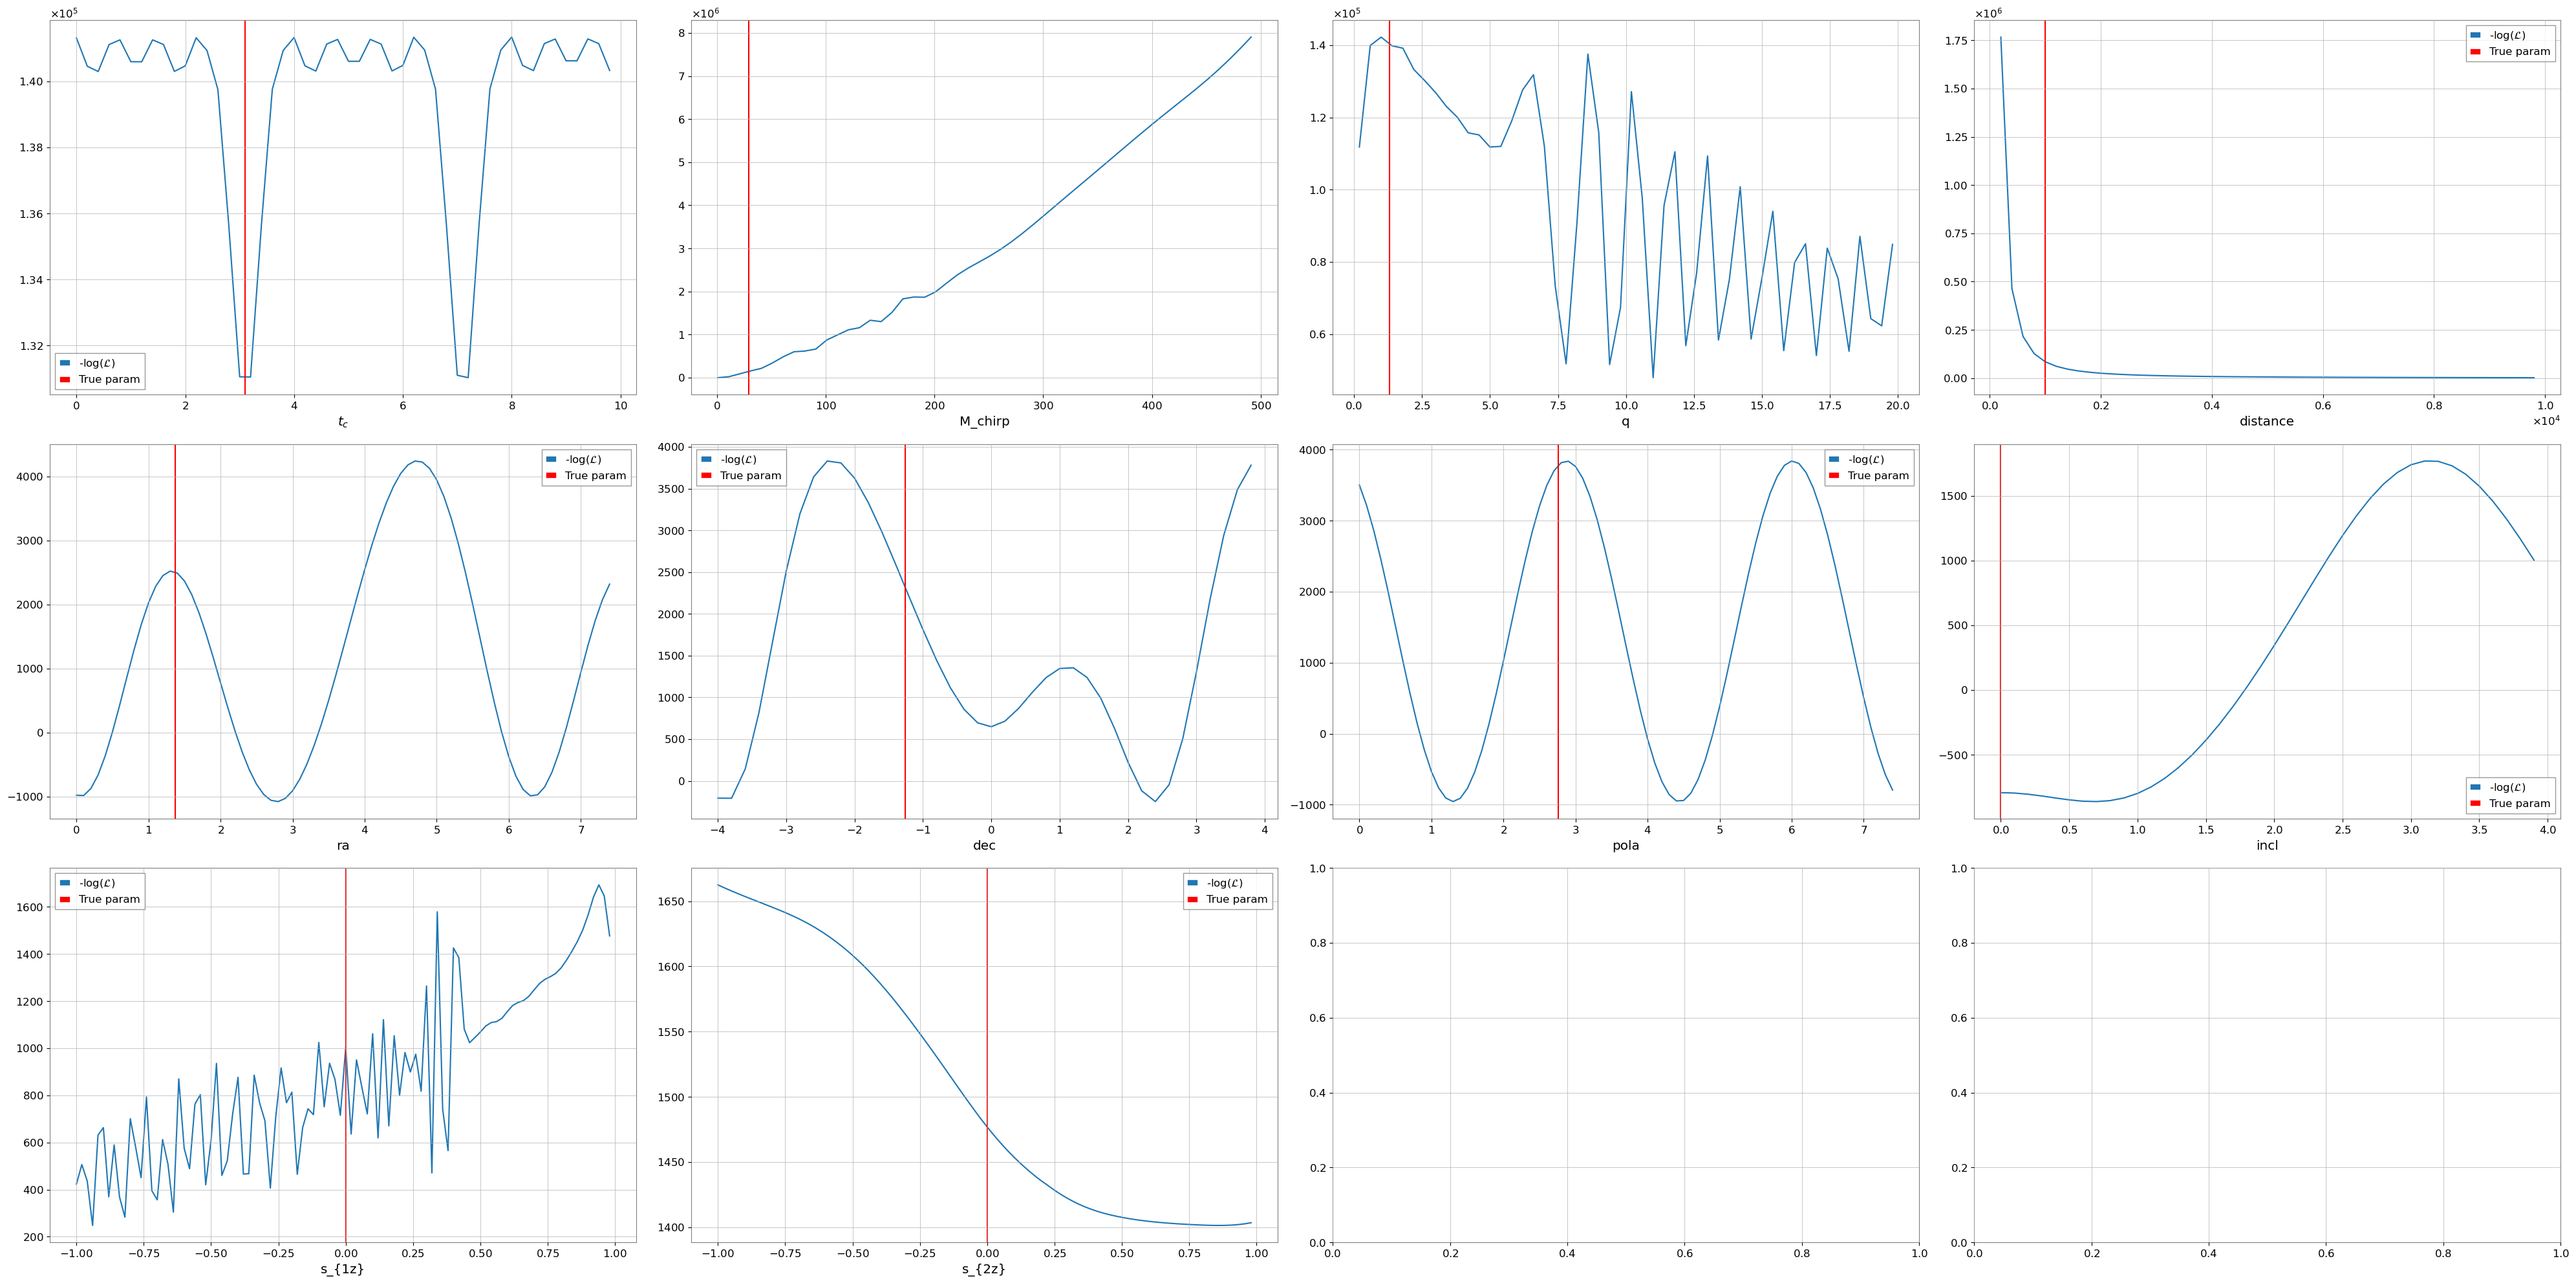

In [33]:
para_reels = np.array([3.1, 38.6, 29.3, 1000, 1.37, -1.26,2.76,0,0,0])
save_fig = False
model = model_noise
fig_lik, axs = plt.subplots(nrows=3, ncols=4, figsize = (40,20))

true_param = para_reels

def plot_lik(ax,data_x,label_x,true_param,param_min,param_max,echantill,params_dataFrame):

    model.update(tc=true_param[0], mass1 = true_param[1], mass2 = true_param[2], distance = true_param[3],
                ra = true_param[4], dec = true_param[5], polarization = true_param[6], declination = true_param[7],
                spin1z = true_param[8], spin2z = true_param[9])

    mchirp_true = mchirp_from_mass1_mass2(true_param[1],true_param[2])
    q_true = q_from_mass1_mass2(true_param[1],true_param[2])

    index_x = params_dataFrame.columns.get_loc(data_x) - 1

    x_grid = np.arange(param_min[index_x],param_max[index_x],echantill[index_x])
    y_grid = np.zeros(len(x_grid))
    for i, x_ in enumerate(x_grid):
        if data_x == 'mass1' :
            mass1 = mass1_from_mchirp_q(mchirp=x_,q=q_true)
            mass2 = mass2_from_mchirp_q(mchirp=x_,q=q_true)
            params = {'mass1' : mass1, 'mass2' : mass2}
            model.update(**params)
            y_grid[i]=-model.loglr
        elif data_x == 'mass2' :
            mass1 = mass1_from_mchirp_q(mchirp=mchirp_true,q=x_)
            mass2 = mass2_from_mchirp_q(mchirp=mchirp_true,q=x_)
            params = {'mass1' : mass1, 'mass2' : mass2}
            model.update(**params)
            y_grid[i]=-model.loglr
        else :
            params = {data_x : x_} #Les paramètres que l'on souhaite modifier sur le modèle de notre GW
            model.update(**params) #Modification du modèle 
            y_grid[i]=-model.loglr
    ax.plot(x_grid,y_grid,label = r"-log($\mathcal{L}$)")
    if data_x == 'mass1' :
        ax.set_xlabel('M_chirp')
        ax.axvline(mchirp_true,color = 'red',label = 'True param')
    elif data_x == 'mass2' :
        ax.set_xlabel('q')
        ax.axvline(q_true,color = 'red',label = 'True param')
    else :
        ax.set_xlabel(label_x)
        ax.axvline(true_param[index_x],color = 'red',label = 'True param')
        ax.legend()

axs_list = [axs[0,0],axs[0,1],axs[0,2],axs[0,3],axs[1,0],axs[1,1],axs[1,2],axs[1,3],axs[2,0],axs[2,1]]
label_x = [r'$t_c$', r'$m_1$', r'$m_2$',  r'distance',   r'ra',      r'dec',     r'pola',        r'incl',       r's_{1z}',  r's_{2z}']
data_x = ['tc',   'mass1',    'mass2',    'distance',    'ra',       'dec',      'polarization', 'inclination', 'spin1z',   'spin2z']
param_min = [0,     1, 0.2,    200,   0,  -4,   0,   0,   -1,   -1]
param_max = [10,  500,  20, 10000, 7.5,   4, 7.5,   4,    1,    1]
echantill = [0.2,   10, 0.4,    200, 0.1, 0.2, 0.1, 0.1, 0.02, 0.02]

q=0
for i in range(len(label_x)):
    plot_lik(axs_list[i],data_x[i],label_x[i],true_param,param_min,param_max,echantill,params_dataFrame)
    q += 1
    print('graph {} fini'.format(q),end='\r')

fig_lik.tight_layout()

if save_fig :
    plt.savefig("variation_params_minimisation")


Visualisation des paramètres après optimisation.

In [ ]:
print_results(result_glob,para_reels,initial_params)

Paramètres initiaux :
$t_c$ : 2, $m_1$ : 30, $m_2$ : 30, $d_L$ : 5000, ra : 4, dec : 0, pola : 4, incl : 2, s1z : 0, s2z : 0.

Paramètres d'optimisation trouvés (local) :
$t_c$ : 1.82, $m_1$ : 33.97, $m_2$ : 28.07, $d_L$ : 6559.63, ra : 2.85, dec : -0.0, pola : 3.48, incl : 2.02, s1z : 0.0, s2z : 0.0.

Paramètres réels :
$t_c$ : 3.1, $m_1$ : 38.6, $m_2$ : 29.3, $d_L$ : 1000.0, ra : 1.37, dec : -1.26, pola : 2.76, incl : 0.0, s1z : 0.0, s2z : 0.0.


Evolution de la minimisation.

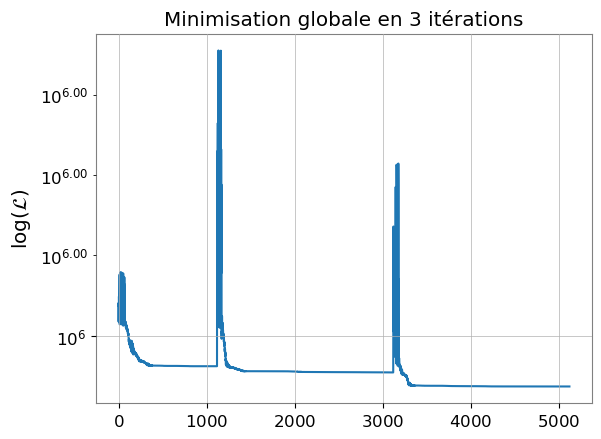

In [ ]:
ll_ratio_test=params_dataFrame_glob['mloglik']
x_ = np.arange(len(ll_ratio_test))
plt.plot(x_,ll_ratio_test)
plt.ylabel(r'log($\mathcal{L}$)')
plt.title('Minimisation globale')
plt.savefig('minimisation/plot_A')

Plot des graphs d'évolution de la minimisation pour toutes les combinaisons de paramètres associées à notre minimisation : minimums LOCAUX + sauvegarde de la figure dans le dossier partagé Github.

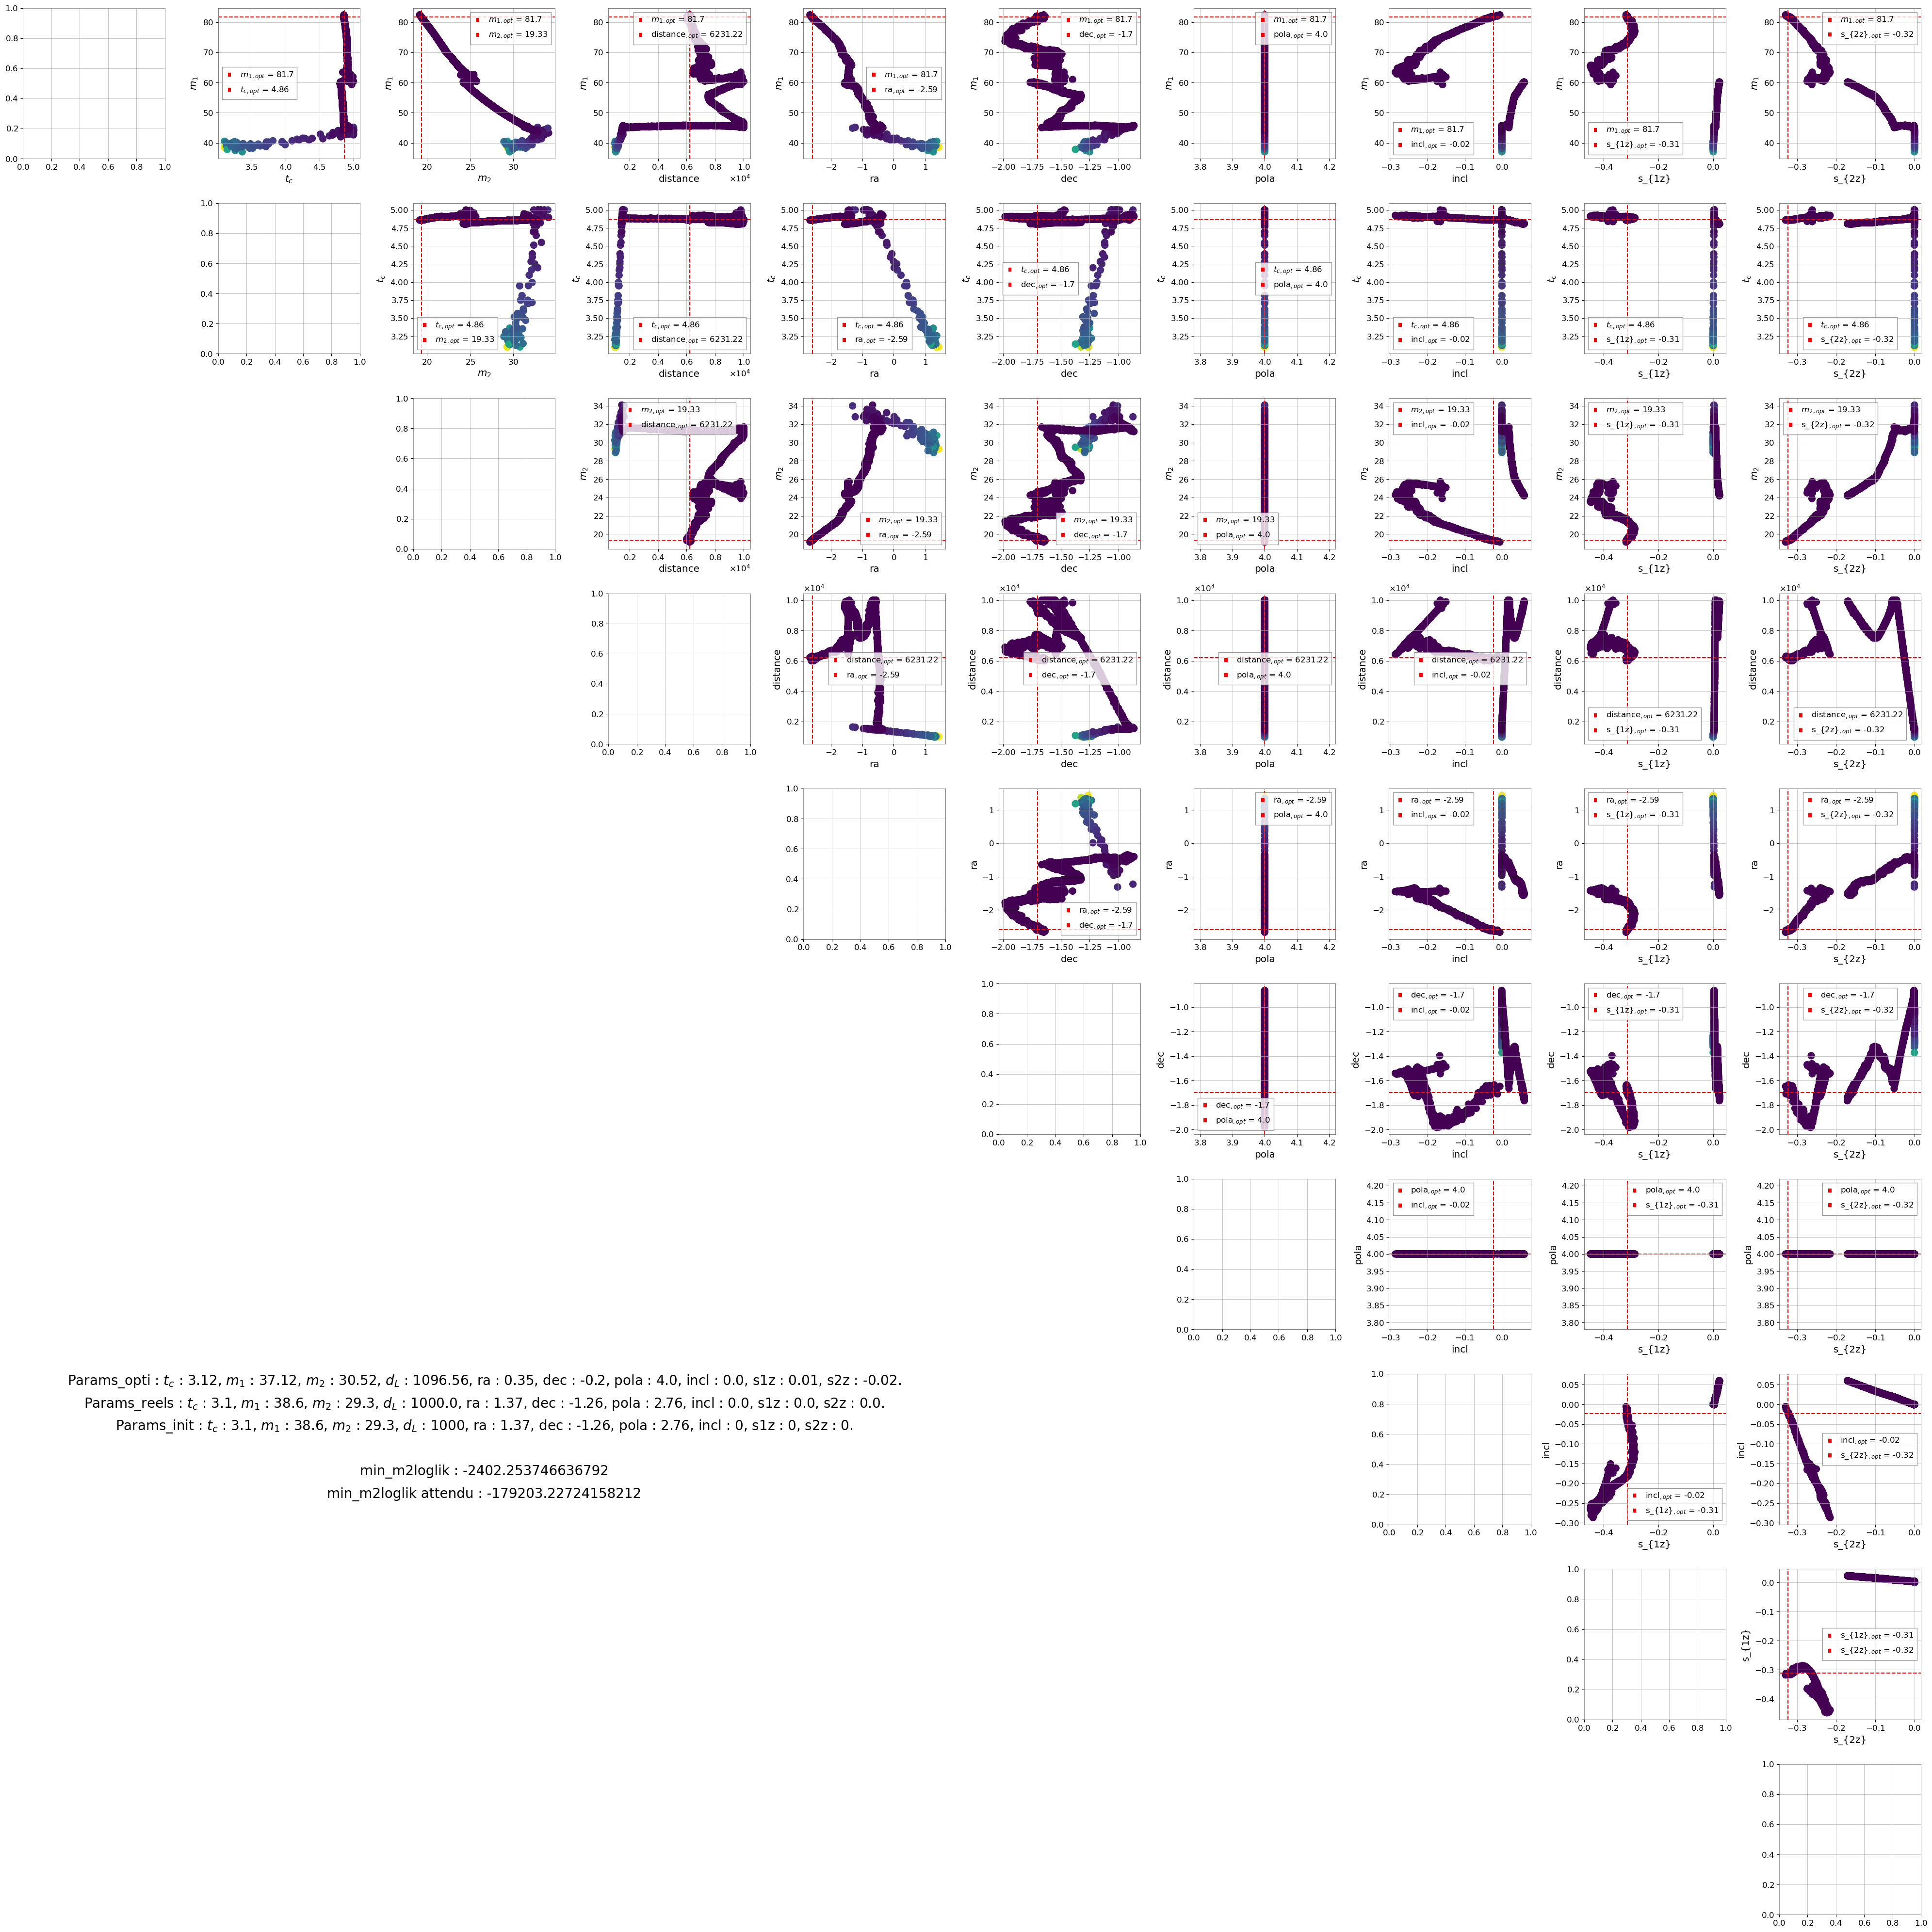

In [ ]:
plot_mnimisation(params_dataFrame_glob,result,para_reels,initial_params,log_noise_likelihood_from_SNR,mini='glob',save_fig=False)

Plot des corrélations des différents paramètres de notre GW. Nous faisons une gille 2D pour chaque combinaison de 2 paramètres (laissés libres) et nous fixons tous les autres à leur valeur réelle.

Plots total : 45, plot : 1
Iterations totales :  900
(30, 30)
Maximum log-likelihood ratio at:5583.701859894543
inclination = 0.9
mass1 = 38.52


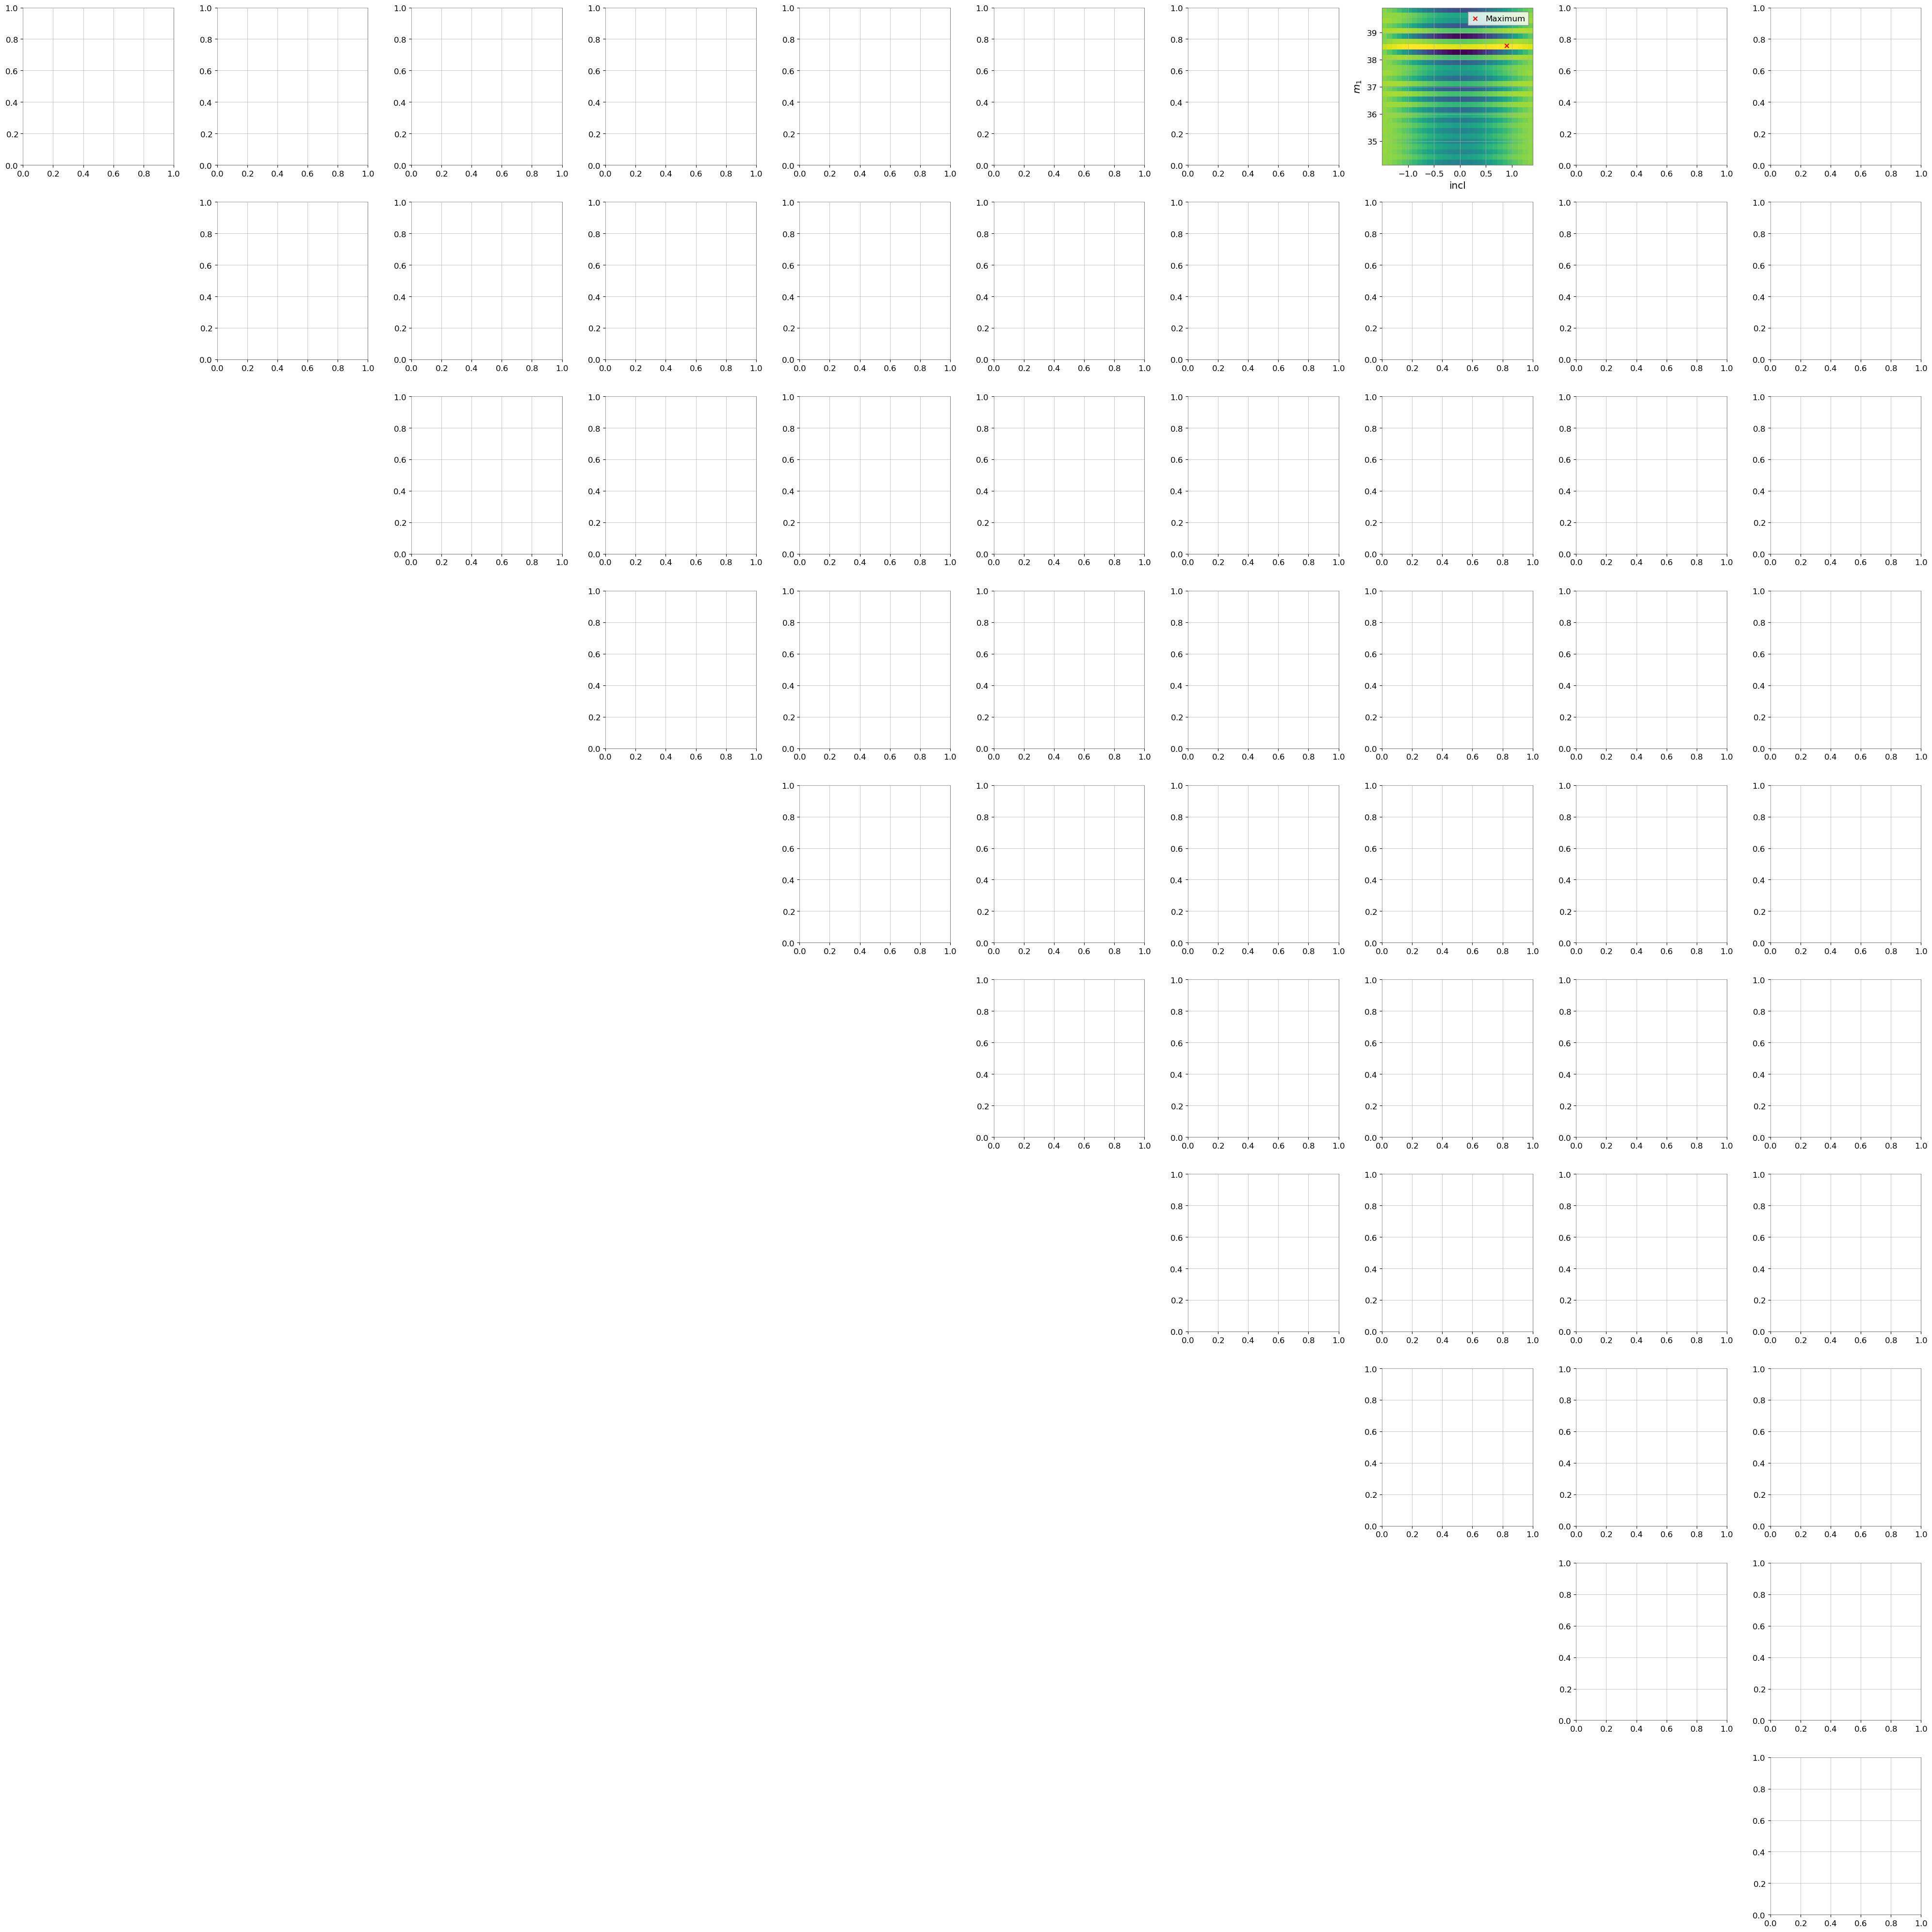

In [ ]:
plot_correlation(params_dataFrame_glob,model_noise,para_reels,cbc_params,save_fig=False)

Plot pour graph de corrélation avec seulement 2 paramètres.

Iterations totales :  5400
(180, 30)
Maximum log-likelihood ratio at:193501.50059718842
distance = 1000
inclination = 0.0


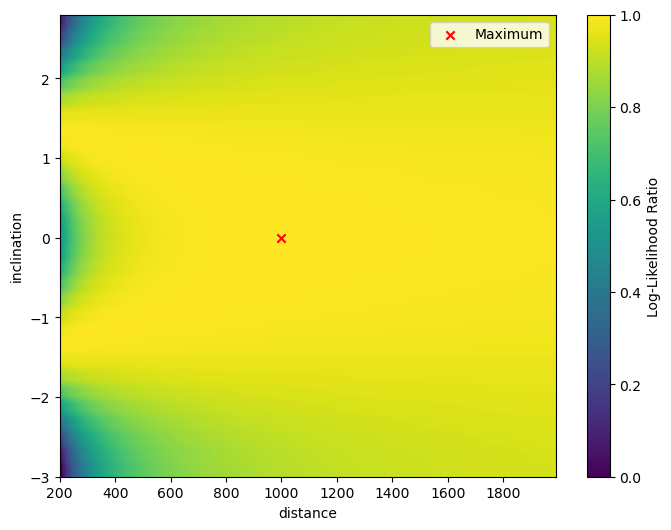

In [ ]:
x_data = 'distance'
y_data = 'inclination'
x_label = x_data
y_label = y_data
borne_x, ech_x = 500,10
borne_y, ech_y = 3,0.2

plot_correlation_2_params(model_noise,cbc_params,x_data,y_data,borne_x,borne_y,ech_x,ech_y,x_label,y_label,save_fig=False)

Plot pour graph de corrélation entre la mass ratio et la chrip mass : on constate donc que ces deux paramètres dont décorrélés et il est donc préférable de les utiliser dans la minimisation plutôt que $m_1$ et $m_2$.

In [ ]:
plot_correlation_chirp_q(model_noise,cbc_params,save_fig=False)

37.11580750625587
37.11580750625587
30.52473415640889
30.52473415640889
Chirp mass of the system: 29.274202120237604
Mass ratio of the system: 1.2159256593709968
